# Pipeline Project

Build a machine learning model to predict whether a customer would recommend
a product.

## The Data

The dataset has been anonymized and cleaned of missing values.

There are 8 features for to use to predict whether a customer recommends or does
not recommend a product.
The `Recommended IND` column gives whether a customer recommends the product
where `1` is recommended and a `0` is not recommended.
This is your model's target/

The features can be summarized as the following:

- **Clothing ID**: Integer Categorical variable that refers to the specific piece being reviewed.
- **Age**: Positive Integer variable of the reviewers age.
- **Title**: String variable for the title of the review.
- **Review Text**: String variable for the review body.
- **Positive Feedback Count**: Positive Integer documenting the number of other customers who found this review positive.
- **Division Name**: Categorical name of the product high level division.
- **Department Name**: Categorical name of the product department name.
- **Class Name**: Categorical name of the product class name.

The target:
- **Recommended IND**: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

## Packages

In [1]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from text_preprocessing_tools import CountCharacter, SpacyLemmatizer, CountWords
from my_functions import model_evaluation

### Load Data

In [2]:
df = pd.read_csv('data/reviews.csv')

df.info()
df.head()

data = df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18442 entries, 0 to 18441
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              18442 non-null  int64 
 1   Age                      18442 non-null  int64 
 2   Title                    18442 non-null  object
 3   Review Text              18442 non-null  object
 4   Positive Feedback Count  18442 non-null  int64 
 5   Division Name            18442 non-null  object
 6   Department Name          18442 non-null  object
 7   Class Name               18442 non-null  object
 8   Recommended IND          18442 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.3+ MB


### Preparing features (X) & target (y)

In [3]:
# separate features from labels
X = data.drop('Recommended IND', axis=1)
y = data['Recommended IND'].copy()

print('Labels:', y.unique())
print('Features:')

X.head()

Labels: [0 1]
Features:


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits


In [4]:
# Split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    shuffle=True,
    random_state=27,
)

### Data Exploration

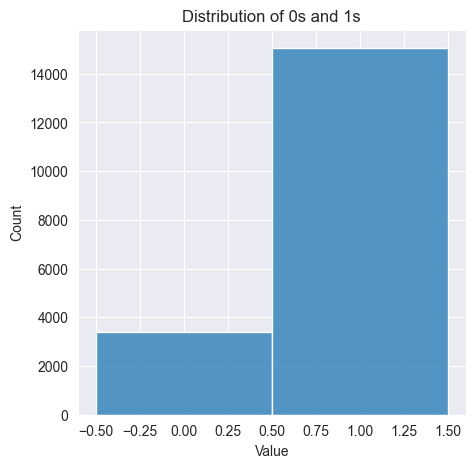

In [15]:
# visualize target distribution 
plt.figure(figsize=(5,5))
sns.histplot(y, bins=2, discrete=True)
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Distribution of 0s and 1s')
plt.show()

In [5]:
# check the number of categories for the categorical features
len(X["Clothing ID"].unique())
X["Division Name"].unique()
X["Department Name"].unique()
X["Class Name"].unique()

# extract features
num_features = (X
                .select_dtypes(exclude=['object']).columns
                .drop("Clothing ID"))
text_features = ["Title", "Review Text"]
cat_features = X.select_dtypes(include=['object']).columns
cat_features = cat_features.drop(text_features)

# Extract unique words
unique_words = set(word for row in X['Title'] for word in row.split())

In [6]:
# Define vocabulary for tfidf_pipeline
custom_vocab = [
    # positive
    "great", "amazing", "super", "cute", "nice", "beautiful",
    "adorable", "like", "love", "perfect", "wonderful", "soft"

    # negative
    "bad", "horrible", "but", "not", "problem", "disappoint"

    # neutral
    "quality", "large", "small", "okay", "unique", "comfort", "very"

]

### Building pipeline
Generate pipelines to handle both categorical, and text data.

Numerical features are not scaled, as it is not required by random forest

In [7]:
# load spacy
nlp = spacy.load("en_core_web_sm")

# categorical pipeline
cat_pipeline = Pipeline([
    ("cat_encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore")),
])

# extract features from text data and put into pipeline
feature_counts = FeatureUnion([
    ('count_dots', CountCharacter(character='...')),
    ('count_exclamations', CountCharacter(character='!')),
    ('count_question_marks', CountCharacter(character='?')),
    ('count_words', CountWords()),
])

text_pipeline = Pipeline([
    ('features', feature_counts),
])

text_feature_pipeline = ColumnTransformer([
    ('title_counts', text_pipeline, 'Title'),
    ('review_counts', text_pipeline, 'Review Text')
])

# perform tfidf and put into pipeline
tfidf_pipeline = Pipeline([
    (
        'dimension_reshaper',
        FunctionTransformer(
            np.reshape,
            kw_args={'newshape': -1},
        ),
    ),
    (
        'lemmatizer',
        SpacyLemmatizer(nlp=nlp),
    ),
    (
        'tfidf_vectorizer',
        TfidfVectorizer(
            stop_words='english',
            min_df=2,
            vocabulary=custom_vocab,
        ),
    ),
])

# generate final feature engineering pipeline
feature_engineering = ColumnTransformer([
    # Counts
    ('title_counts', text_pipeline, 'Title'),
    ('review_counts', text_pipeline, 'Review Text'),
    # TFIDF
    ('title_tfidf', tfidf_pipeline, "Title"),
    ('review_tfidf', tfidf_pipeline, "Review Text"),
    # Numerical features
    ('num_features', 'passthrough', num_features),
    # Categorical features
    ('cat_features', cat_pipeline, cat_features),
])

### Training pipeline

In [8]:
# check shape
#transformed_features = feature_engineering.fit_transform(X_train)
#print(transformed_features.shape)

model_pipeline = make_pipeline(
    feature_engineering,
    RandomForestClassifier(random_state=27, verbose=1),
)
model_pipeline.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('title_counts',
                                                  Pipeline(steps=[('features',
                                                                   FeatureUnion(transformer_list=[('count_dots',
                                                                                                   CountCharacter(character='...')),
                                                                                                  ('count_exclamations',
                                                                                                   CountCharacter(character='!')),
                                                                                                  ('count_question_marks',
                                                                                                   CountCharacter(character='?')),
                                                                                                  ('count_words',
                                                                                                   CountWords())]))]),
                                                  'Title'),
                                                 ('review...
                                                  'Review Text'),
                                                 ('num_features', 'passthrough',
                                                  Index(['Age', 'Positive Feedback Count'], dtype='object')),
                                                 ('cat_features',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Division Name', 'Department Name', 'Class Name'], dtype='object'))])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=27, verbose=1))])

### Fine-tuning pipeline

In [9]:
my_distributions = dict(
    randomforestclassifier__max_features=[
        10, 20, 30
    ],
    randomforestclassifier__n_estimators=[
        50, 100, 150
    ],
)

param_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=my_distributions,
    cv=5,
    scoring='accuracy',
    n_jobs=1,
    refit=True,
    verbose=3
)


In [10]:
# fit the tuned pipeline
param_search.fit(X_train, y_train)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 1/5] END randomforestclassifier__max_features=10, randomforestclassifier__n_estimators=50;, score=0.821 total time= 2.7min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 2/5] END randomforestclassifier__max_features=10, randomforestclassifier__n_estimators=50;, score=0.826 total time= 2.7min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 3/5] END randomforestclassifier__max_features=10, randomforestclassifier__n_estimators=50;, score=0.825 total time= 2.7min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 4/5] END randomforestclassifier__max_features=10, randomforestclassifier__n_estimators=50;, score=0.807 total time= 2.7min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 5/5] END randomforestclassifier__max_features=10, randomforestclassifier__n_estimators=50;, score=0.814 total time= 2.7min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 1/5] END randomforestclassifier__max_features=10, randomforestclassifier__n_estimators=100;, score=0.820 total time= 2.8min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 2/5] END randomforestclassifier__max_features=10, randomforestclassifier__n_estimators=100;, score=0.824 total time= 2.7min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 3/5] END randomforestclassifier__max_features=10, randomforestclassifier__n_estimators=100;, score=0.824 total time= 2.7min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 4/5] END randomforestclassifier__max_features=10, randomforestclassifier__n_estimators=100;, score=0.809 total time= 2.7min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 5/5] END randomforestclassifier__max_features=10, randomforestclassifier__n_estimators=100;, score=0.819 total time= 2.8min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 1/5] END randomforestclassifier__max_features=10, randomforestclassifier__n_estimators=150;, score=0.824 total time= 2.8min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 2/5] END randomforestclassifier__max_features=10, randomforestclassifier__n_estimators=150;, score=0.826 total time= 2.7min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 3/5] END randomforestclassifier__max_features=10, randomforestclassifier__n_estimators=150;, score=0.825 total time= 2.8min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 4/5] END randomforestclassifier__max_features=10, randomforestclassifier__n_estimators=150;, score=0.808 total time= 2.8min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 5/5] END randomforestclassifier__max_features=10, randomforestclassifier__n_estimators=150;, score=0.821 total time= 2.8min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 1/5] END randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=50;, score=0.821 total time= 2.7min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 2/5] END randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=50;, score=0.823 total time= 2.7min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 3/5] END randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=50;, score=0.818 total time= 2.7min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 4/5] END randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=50;, score=0.809 total time= 2.7min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 5/5] END randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=50;, score=0.819 total time= 2.7min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 1/5] END randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=100;, score=0.820 total time= 2.7min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 2/5] END randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=100;, score=0.827 total time= 2.7min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 3/5] END randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=100;, score=0.820 total time= 3.0min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 4/5] END randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=100;, score=0.813 total time= 2.7min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 5/5] END randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=100;, score=0.821 total time= 2.7min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 1/5] END randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=150;, score=0.824 total time= 2.8min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 2/5] END randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=150;, score=0.828 total time= 2.8min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 3/5] END randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=150;, score=0.823 total time= 2.8min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 4/5] END randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=150;, score=0.812 total time= 2.8min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 5/5] END randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=150;, score=0.822 total time= 2.8min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 1/5] END randomforestclassifier__max_features=30, randomforestclassifier__n_estimators=50;, score=0.818 total time= 2.7min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 2/5] END randomforestclassifier__max_features=30, randomforestclassifier__n_estimators=50;, score=0.822 total time= 2.7min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 3/5] END randomforestclassifier__max_features=30, randomforestclassifier__n_estimators=50;, score=0.817 total time= 2.7min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 4/5] END randomforestclassifier__max_features=30, randomforestclassifier__n_estimators=50;, score=0.809 total time= 2.7min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 5/5] END randomforestclassifier__max_features=30, randomforestclassifier__n_estimators=50;, score=0.816 total time= 2.7min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 1/5] END randomforestclassifier__max_features=30, randomforestclassifier__n_estimators=100;, score=0.824 total time= 2.8min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 2/5] END randomforestclassifier__max_features=30, randomforestclassifier__n_estimators=100;, score=0.821 total time= 2.8min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 3/5] END randomforestclassifier__max_features=30, randomforestclassifier__n_estimators=100;, score=0.821 total time= 2.8min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 4/5] END randomforestclassifier__max_features=30, randomforestclassifier__n_estimators=100;, score=0.808 total time= 2.8min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 5/5] END randomforestclassifier__max_features=30, randomforestclassifier__n_estimators=100;, score=0.820 total time= 2.8min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 1/5] END randomforestclassifier__max_features=30, randomforestclassifier__n_estimators=150;, score=0.824 total time= 2.8min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 2/5] END randomforestclassifier__max_features=30, randomforestclassifier__n_estimators=150;, score=0.821 total time= 2.8min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 3/5] END randomforestclassifier__max_features=30, randomforestclassifier__n_estimators=150;, score=0.820 total time= 2.8min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 4/5] END randomforestclassifier__max_features=30, randomforestclassifier__n_estimators=150;, score=0.811 total time= 2.8min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV 5/5] END randomforestclassifier__max_features=30, randomforestclassifier__n_estimators=150;, score=0.823 total time= 2.8min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('title_counts',
                                                                         Pipeline(steps=[('features',
                                                                                          FeatureUnion(transformer_list=[('count_dots',
                                                                                                                          CountCharacter(character='...')),
                                                                                                                         ('count_exclamations',
                                                                                                                          CountCharacter(character='!')),
                                                                                                                         ('count_question_marks',
                                                                                                                          CountCharacter(character='?')),
                                                                                                                         ('count_words',
                                                                                                                          CountWor...
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         Index(['Division Name', 'Department Name', 'Class Name'], dtype='object'))])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=27,
                                                               verbose=1))]),
             n_jobs=1,
             param_grid={'randomforestclassifier__max_features': [10, 20, 30],
                         'randomforestclassifier__n_estimators': [50, 100,
                                                                  150]},
             scoring='accuracy', verbose=3)

In [11]:
# Retrieve the best parameters
param_search.best_params_
model_best = param_search.best_estimator_

print(param_search.best_params_)

{'randomforestclassifier__max_features': 20, 'randomforestclassifier__n_estimators': 150}


### Model evaluation - TRAIN

In [12]:
y_train_base_pred = model_pipeline.predict(X_train)
y_train_tune_pred = model_best.predict(X_train)

r1 = model_evaluation(y=y_train, y_pred=y_train_base_pred, split="train", tune="base")
r2 = model_evaluation(y=y_train, y_pred=y_train_tune_pred, split="train", tune="tune")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


### Model evaluation - TEST

In [13]:
y_test_base_pred = model_pipeline.predict(X_test)
y_test_tune_pred = model_best.predict(X_test)

r3 = model_evaluation(y=y_test, y_pred=y_test_base_pred, split="test", tune="base")
r4 = model_evaluation(y=y_test, y_pred=y_test_tune_pred, split="test", tune="tune")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


### Visualization of results

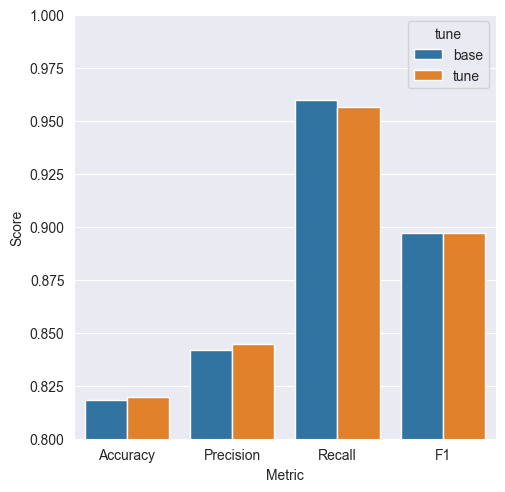

In [14]:
results = pd.concat([r3, r4])

plt.figure(figsize=(5,5))
sns.barplot(results, x="metric", y="score", hue="tune", legend=True)
plt.tight_layout()
plt.ylabel("Score")
plt.xlabel("Metric")
plt.ylim(0.8,1)
plt.savefig("img/results.png", dpi=300, bbox_inches='tight')

### Interpretation

Both the base and the tuned model lead to high performance across accuracy, precision, recall, f1-score (>0.8). Both models perform comparably. 